# Control for articulatory length representation of 7 words

## Generate audio for set of 7 words to estimate word articulatory length using AWS Polly TTS model

In [5]:
import os
import boto3
from pydub import AudioSegment
import pandas as pd
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from tqdm import tqdm
from joblib import Parallel, delayed
import statsmodels.api as sm

import sys
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', 'cvDistance'))
from subfunctions.cvVectorStats.cvDistance import cvDistance

In [80]:
DIR_DATA = '../../../data'

FP_OPTIMAL_WINDOWS = os.path.join(DIR_DATA, 'optimalWindowsAll.mat')
FP_T12_ALLBHVR = os.path.join(DIR_DATA, 't12.2023.08.15', 't12.2023.08.15_allBehaviors_raw.mat')
FP_T15_ALLBHVR = os.path.join(DIR_DATA, 't15.2024.04.07', 't15.2024.04.07_allBehaviors_raw.mat')
FP_T16_ALLBHVR = os.path.join(DIR_DATA, 't16.2024.03.04', 't16.2024.03.04_allBehaviors_raw.mat')
FP_T17_ALLBHVR = os.path.join(DIR_DATA, 't17.2024.12.09', 't17.2024.12.09_allBehaviors_raw.mat')

'''
first index is participant in numerical order, second is behavior in same order as table, third is array, ventral to dorsal

the optimal windows are all in reference to teh goTrialEpochs(:,1) for everything (so for listenign / reading its negative values
'''
PARTICIPANT_ARRAYS_WIN_IDXS = {'t12': ['i6v', 's6v'],
                               't15': ['i6v', 'M1', 's6v', '55b'],
                               't16': ['i6v', 'PEF', '6d'], 
                               't17': ['s6v-v', 's6v-d', '55b']}

# subset of arrays to use for plotting to match figure 1 decoding heat map
PARTICIPANT_ARRAYS_PLOTTING = ['t15 55b', 't15 s6v', 't12 s6v', 't17 s6v-d', 't17 s6v-v', 't15 M1', 't15 i6v', 't12 i6v', 't16 i6v']
PARTICIPANT_ARRAYS_PLOTTING_RELABELED        = ['T15-55b', 'T15-s6v', 'T12-s6v', 'T17-s6v', 'T17-s6v', 'T15-4',   'T15-i6v', 'T12-i6v', 'T16-i6v']
PARTICIPANT_ARRAYS_PLOTTING_RELABELED_COLORS = ['#62469C', '#36BFC3', '#36BFC3', '#36BFC3', '#36BFC3', "#70BF44", "#CD2128", "#CD2128", "#CD2128"]
NOT_SIGNIFICANT_DECODING_ARRAYS_FIGURE1 = [('t15 55b', 'imagined1stAuditory'), ('t15 55b', 'reading'),
                                             ('t15 s6v', 'imagined1stMotor'), ('t15 s6v', 'imagined1stAuditory'), ('t15 s6v', 'imaginedListening'), ('t15 s6v', 'listening'), ('t15 s6v', 'reading'),
                                             ('t12 s6v', 'imagined1stMotor'), ('t12 s6v', 'imagined1stAuditory'), ('t12 s6v', 'imaginedListening'), ('t12 s6v', 'listening'), ('t12 s6v', 'reading'),
                                             ('t17 s6v-d', 'listening'), ('t17 s6v-d', 'reading'),
                                             ('t17 s6v-v', 'imagined1stMotor'), ('t17 s6v-v', 'reading'),
                                             ('t15 M1', 'imagined1stMotor'), ('t15 M1', 'imagined1stAuditory'),
                                             ]


BEHAVIORS = ['attempted', 'mouthed', 'imagined1stMotor', 'imagined1stAuditory', 'imaginedListening', 'listening', 'reading']
BEHAVIORS_PLOTTING_RELABELED  = ['Attempted', 'Mimed', 'Motoric Inner Speech', 'Auditory Inner Speech', 'Imagined Listening', 'Listening', 'Silent Reading']
WORDS = ['ban', 'choice', 'day', 'feel', 'kite', 'though', 'were']

FP_SVG_OUT = '/Users/bmesc/Documents/school/gradschool/NPTL/papers/imaginedSpeech/articulatory_length_control.svg'
FP_PNG_OUT = '/Users/bmesc/Documents/school/gradschool/NPTL/papers/imaginedSpeech/articulatory_length_control.png'


In [4]:
def blockwise_mean_subtract(all_bhvr_mat, neural_features = ['binnedTX', 'spikePow'], convert_to_python_idxs = True, idx_keys = ['trialCues', 'goTrialEpochs', 'delayTrialEpochs']):
    """blockwise mean suctraction to limit effect of nonstationarity in neural data over course of session
    edits neural data IN PLACE

    Also can convert matlab indices to python indexing

    Parameters
    ----------
    all_bhvr_mat : dict
        neural and task data from sweep of all behaviors
    neural_features : list, optional
        keys in mat contents for binned neural features, by default ['binnedTX', 'spikePow']
    """
    # re-index cetain keys for python indexing
    if convert_to_python_idxs:
        for key in idx_keys:
            all_bhvr_mat[key] = all_bhvr_mat[key] - 1

        for area_idx in range(len(all_bhvr_mat['chanSets'])):
            all_bhvr_mat['chanSets'][area_idx] = all_bhvr_mat['chanSets'][area_idx] - 1

    for block in np.unique(all_bhvr_mat['blockNum']):
        block_idxs = all_bhvr_mat['blockNum'] == block
        for neural_feature in neural_features:
            block_mean = np.mean(all_bhvr_mat[neural_feature][block_idxs], axis=0)
            all_bhvr_mat[neural_feature][block_idxs] = all_bhvr_mat[neural_feature][block_idxs] - block_mean



def text_to_mp3(text, voice_id='Joanna', region='us-east-1', save_mp3_dir = '', save_mp3=False):
    """
    Convert text speech duration (i.e. articulatory length) with optional saving of mp3 file
    requires configured aws cli
    """
    # Initialize Polly client
    polly = boto3.client('polly', region_name=region)

    # Synthesize speech (MP3 format)
    response = polly.synthesize_speech(
        Text=text,
        VoiceId=voice_id,
        OutputFormat='mp3'
    )
    
    # Write the MP3 to a temporary file
    fp_mp3 = os.path.join(save_mp3_dir, f"{text}_{voice_id}.mp3")

    with open(fp_mp3, 'wb') as f:
        f.write(response['AudioStream'].read())

    # read mp3 and get it's duration in seconds
    audio = AudioSegment.from_mp3(fp_mp3)
    duration_milliseconds = len(audio)
    if not save_mp3:
        os.remove(fp_mp3)
    return duration_milliseconds

In [5]:
duration = []
for w in WORDS:
    duration.append(text_to_mp3(w))

word_durations = pd.DataFrame({'word': WORDS, 'duration(ms)': duration}).set_index('word')
word_durations

duration(ms)
word                
ban              444
choice           575
day              470
feel             522
kite             522
though           418
were             366

## Do differences in articulatory length explain differences in neural distance? 
If articualtory length is encoded in neural activity, then the relative differences in duration of articulation should correlate with the relative differences in euclidean distance between words

In [6]:
'''
first index is participant in numerical order, second is behavior in same order as table, third is array, ventral to dorsal
'''
wins = loadmat(FP_OPTIMAL_WINDOWS, squeeze_me=True)

participant_col = []
array_col = []
behavior_col = []
win_start = []
win_end = []

for participant_idx, (participant, arrays) in enumerate(PARTICIPANT_ARRAYS_WIN_IDXS.items()):
    for behavior_idx, behavior in enumerate(BEHAVIORS):
        for array_idx, array in enumerate(arrays):
            participant_col.append(participant)
            array_col.append(array)
            behavior_col.append(behavior)
            win_start.append(wins['bestWindows'][participant_idx][behavior_idx][array_idx][0])
            win_end.append(wins['bestWindows'][participant_idx][behavior_idx][array_idx][1])

optimal_windows = pd.DataFrame({'participant': participant_col, 'array': array_col, 'behavior': behavior_col,'win_start': win_start, 'win_end': win_end}).set_index(['participant', 'array', 'behavior'])
optimal_windows

win_start win_end
participant array behavior                          
t12         i6v   attempted                0      25
            s6v   attempted               15      40
            i6v   mouthed                  0      25
            s6v   mouthed                 10      35
            i6v   imagined1stMotor       -15      10
...                                      ...     ...
t17         s6v-d listening              -60     -10
            55b   listening             -120     -70
            s6v-v reading                -60     -10
            s6v-d reading               -120     -70
            55b   reading               -100     -50

[84 rows x 2 columns]

In [7]:
MATLAB_INDEX_KEYS = ['trialCues', 'goTrialEpochs']
NEURAL_FEATURES = ['binnedTX', 'spikePow']
NEURAL_FEATURE_JOIN_FCN = [np.sum, np.mean]



participants = []
behavior = []
areas = []
trials = []
words = []
neural_feature = []
channels = []
value = []
for participant, fp_allbhvr_mat in [('t12', FP_T12_ALLBHVR), ('t15', FP_T15_ALLBHVR), ('t16', FP_T16_ALLBHVR), ('t17', FP_T17_ALLBHVR)]:
    all_bhvr = loadmat(fp_allbhvr_mat, squeeze_me=True)
    blockwise_mean_subtract(all_bhvr)
    for bhvr in BEHAVIORS:
        # get behavior trials:
        trials_idxs = [trial_idx for trial_idx in range(len(all_bhvr['trialCues'])) if bhvr in all_bhvr['cueList'][all_bhvr['trialCues'][trial_idx]]]
        for area in PARTICIPANT_ARRAYS_WIN_IDXS[participant]:
            area_idx = np.argwhere(all_bhvr['chanSetNames']==area).squeeze()
            area_channels = all_bhvr['chanSets'][area_idx]
            optimal_win = optimal_windows.loc[(participant, area, bhvr)]
            for trial in trials_idxs:
                # get the neural activity for optimal window of trial
                word = all_bhvr['cueList'][all_bhvr['trialCues'][trial]].split('-')[0]
                go_cue_idx = all_bhvr['goTrialEpochs'][trial, 0]
                win_start = go_cue_idx + optimal_win['win_start']
                win_end = go_cue_idx + optimal_win['win_end']
                for neural_feat, join_fcn in zip(NEURAL_FEATURES, NEURAL_FEATURE_JOIN_FCN):
                    neural_activity = all_bhvr[neural_feat][win_start:win_end, area_channels]
                    # join over time
                    joined_activity = join_fcn(neural_activity, axis=0)

                    channels.append([f'ch{i}' for i in area_channels])
                    n_ch = len(area_channels)
                    participants.append([participant]*n_ch)
                    behavior.append([bhvr]*n_ch)
                    areas.append([area]*n_ch)
                    trials.append([trial]*n_ch)
                    words.append([word]*n_ch)
                    neural_feature.append([neural_feat]*n_ch)

                    value.append(joined_activity)

neural_data = pd.DataFrame({'participant':    np.hstack(participants), 
                            'behavior':       np.hstack(behavior), 
                            'area':           np.hstack(areas), 
                            'trial':          np.hstack(trials), 
                            'word':           np.hstack(words), 
                            'neural_feature': np.hstack(neural_feature),
                            'channel':        np.hstack(channels),
                            'value':          np.hstack(value)
                            })

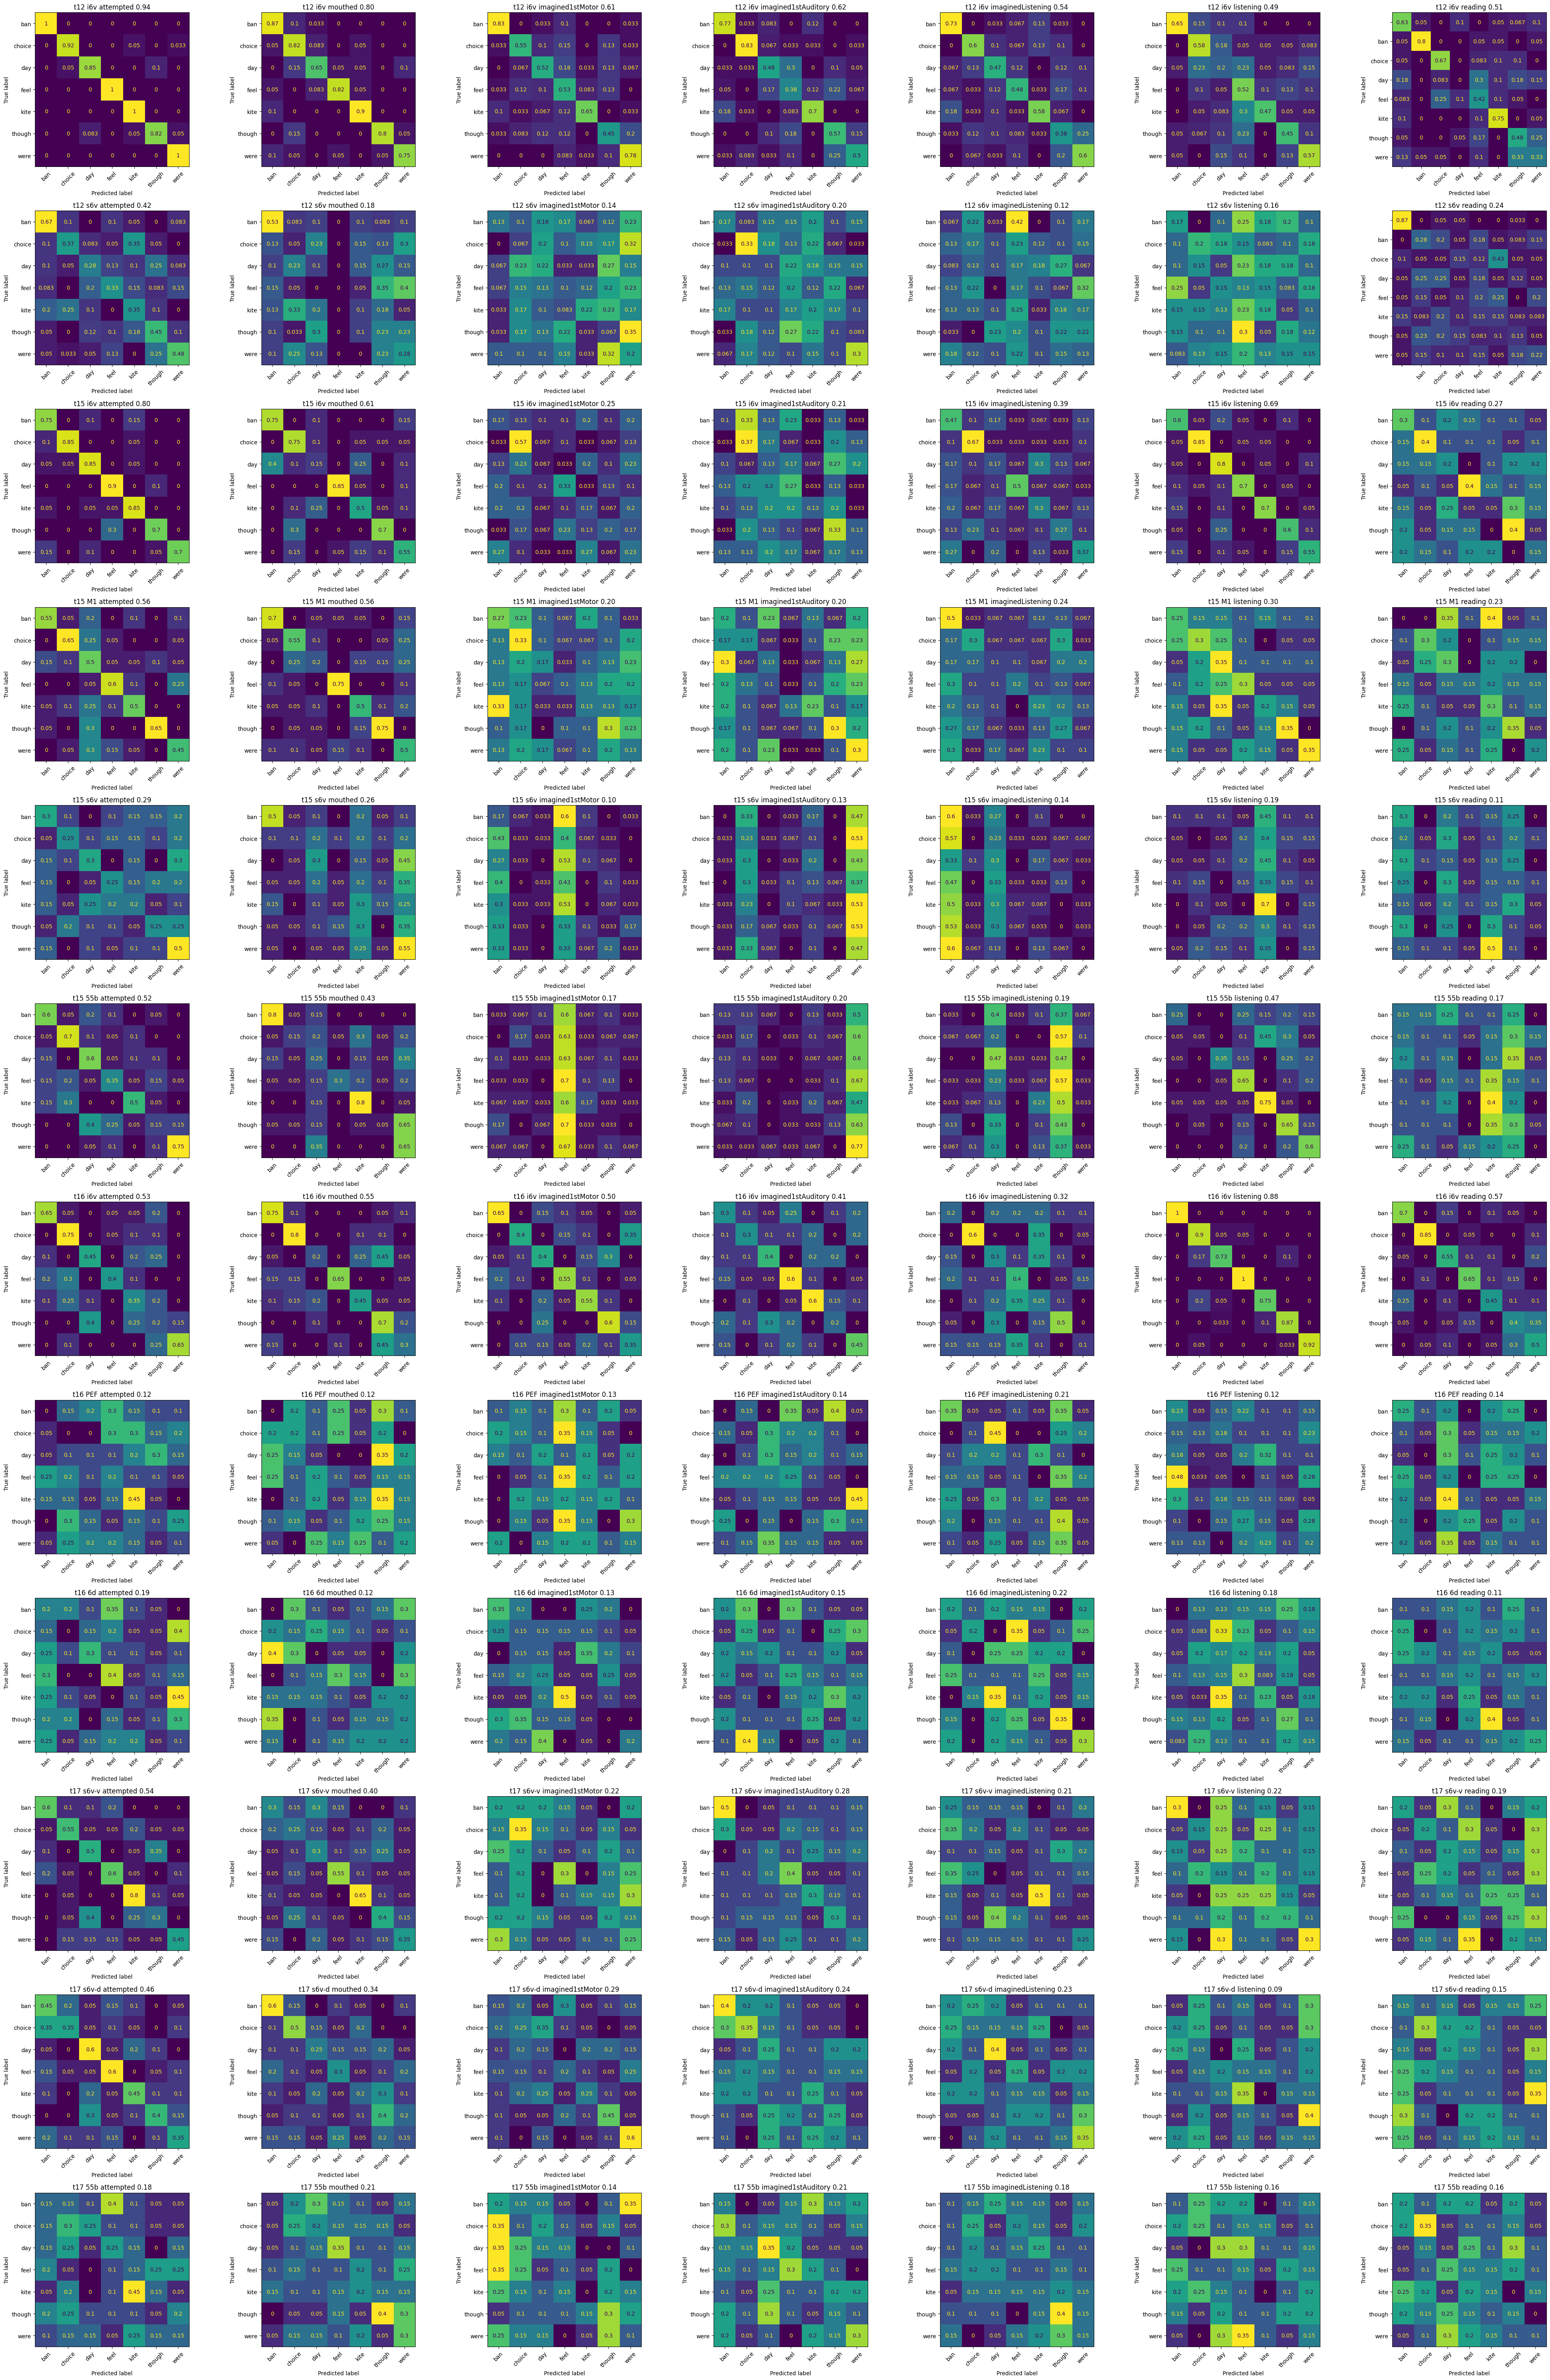

In [8]:
# in some sense best sanity check would be to get the confusion matrices and check they match the matlab ones
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

n_bhvrs = len(BEHAVIORS)
n_participant_areas = len([area for areas in PARTICIPANT_ARRAYS_WIN_IDXS.values() for area in areas])
clf = GaussianNB()
cv = StratifiedKFold(n_splits=10)


# only decoder across active conditions
neural_data_active = neural_data[neural_data.word != 'DO_NOTHING']
fig, axs = plt.subplots(n_participant_areas, n_bhvrs, figsize=(40, 60))

participants = []
arrays = []
behavior = []
decoding_accuracy = []
ax_row = 0
for participant, areas in PARTICIPANT_ARRAYS_WIN_IDXS.items():
    for area_idx, area in enumerate(areas):
        for bhvr_idx, bhvr in enumerate(BEHAVIORS):
            ax = axs[ax_row, bhvr_idx]
            neural_activity = neural_data_active[(neural_data_active['participant'] == participant) & (neural_data_active['area'] == area) & (neural_data_active['behavior'] == bhvr)]
            features_reshaped = neural_activity.pivot_table(
                                            index=['trial', 'word'],
                                            columns=['channel', 'neural_feature'],
                                            values='value'
                                        )            
            
            X = features_reshaped.values
            y = features_reshaped.index.get_level_values('word')

            # plot confusion matrix on ax with title for performance
            confusion_matrices = []
            fold_accuracies = []
            for train_idx, test_idx in cv.split(X, y):
                clf.fit(X[train_idx], y[train_idx])
                y_pred = clf.predict(X[test_idx])

                # fold accuracy
                fold_accuracies.append(accuracy_score(y[test_idx], y_pred))
                confusion_matrices.append(confusion_matrix(y[test_idx], y_pred, labels=clf.classes_, normalize='true'))

            mean_confusion = np.mean(confusion_matrices, axis=0)
            mean_accuracy = np.mean(fold_accuracies)
            disp = ConfusionMatrixDisplay(confusion_matrix=mean_confusion, display_labels=clf.classes_)
            disp.plot(ax=ax, cmap='viridis')  # Use ax for the specified axis
            disp.im_.colorbar.remove()
            ax.set_title(f'{participant} {area} {bhvr} {mean_accuracy:.2f}')
            # rotate x labels for this ax only
            plt.setp(ax.get_xticklabels(), rotation=45)

            participants.append(participant)
            arrays.append(area)
            behavior.append(bhvr)
            decoding_accuracy.append(mean_accuracy)
        ax_row += 1

plt.tight_layout()

In [9]:
decoding_accuracies = pd.DataFrame({'participant': participants, 'array': arrays, 'behavior': behavior, 'decoding_accuracy': decoding_accuracy})

In [10]:
decoding_accuracies

participant array             behavior  decoding_accuracy
0          t12   i6v            attempted           0.939524
1          t12   i6v              mouthed           0.801905
2          t12   i6v     imagined1stMotor           0.611842
3          t12   i6v  imagined1stAuditory           0.615263
4          t12   i6v    imaginedListening           0.540000
..         ...   ...                  ...                ...
79         t17   55b     imagined1stMotor           0.135714
80         t17   55b  imagined1stAuditory           0.207143
81         t17   55b    imaginedListening           0.178571
82         t17   55b            listening           0.164286
83         t17   55b              reading           0.164286

[84 rows x 4 columns]

# Distances analysis
Now for each pair of words, find the neural distance between them as well as the difference in articulatory length.

In [11]:
verbose = 10
n_jobs = -1

# parallelize because it's a lot of distances to compute
def wordpair_neural_dist(participant, area, bhvr, word1, word2, neural_data):
    neural_activity_word1 = neural_data.loc[(participant, area, bhvr, word1)]
    neural_activity_word2 = neural_data.loc[(participant, area, bhvr, word2)]
    features_reshaped_word1 = neural_activity_word1.pivot_table(
                                    index='trial',
                                    columns=['channel', 'neural_feature'],
                                    values='value'
                                )
    features_reshaped_word2 = neural_activity_word2.pivot_table(
                                    index='trial',
                                    columns=['channel', 'neural_feature'],
                                    values='value'
                                )
    
    _, dist_euc, _, _ = cvDistance(features_reshaped_word1.values, features_reshaped_word2.values)
    return pd.Series({'participant': participant, 'area': area, 'behavior': bhvr, 'word_pair': f'{word1} vs {word2}', 'cv neural distance': dist_euc})


neural_data_active = neural_data[neural_data.word != 'DO_NOTHING']

for col in ['participant', 'area', 'behavior', 'word', 'neural_feature', 'channel']:
    neural_data_active.loc[:,col] = neural_data_active[col].astype('category')

neural_data_active.set_index(['participant', 'area', 'behavior', 'word'], inplace=True)
neural_data_active.sort_index(inplace=True)

inputs = []
total=0
for participant, areas in PARTICIPANT_ARRAYS_WIN_IDXS.items():
    for area in areas:
        for bhvr in BEHAVIORS:
            for word1, word2 in combinations(WORDS, r=2):
                inputs.append((participant, area, bhvr, word1, word2, neural_data_active))
                total+=1

print(f'Computing {total} distances')
distances = Parallel(n_jobs=n_jobs, verbose=verbose)(delayed(wordpair_neural_dist)(*input_) for input_ in inputs)
neural_dist_bet_words = pd.DataFrame(distances)

Computing 1764 distances


/var/folders/c6/fcmdv2xj6wx7342n2dl_kblm0000gn/T/ipykernel_63028/3170738960.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neural_data_active.sort_index(inplace=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   12.9s
[Para

In [12]:
# now also get articulatory length differences
articulatory_length_difference = []
word_pairs = []
for word1, word2 in combinations(WORDS, r=2):
    articulatory_length_difference.append(np.abs(word_durations.loc[word1, 'duration(ms)'] - word_durations.loc[word2, 'duration(ms)']))
    word_pairs.append(f'{word1} vs {word2}')

word_pair_articulatory_length_diff = pd.DataFrame({'word_pair': word_pairs, 'articulatory_length_diff(ms)': articulatory_length_difference}).set_index('word_pair')
get_articulatory_diff = lambda word_pair: word_pair_articulatory_length_diff.loc[word_pair, 'articulatory_length_diff(ms)']
neural_dist_bet_words['articulatory length difference (ms)'] = neural_dist_bet_words.word_pair.map(get_articulatory_diff)

# each row should be participant-area pair so need to add that as a column
neural_dist_bet_words['participant_area'] = neural_dist_bet_words['participant'] + ' ' + neural_dist_bet_words['area']

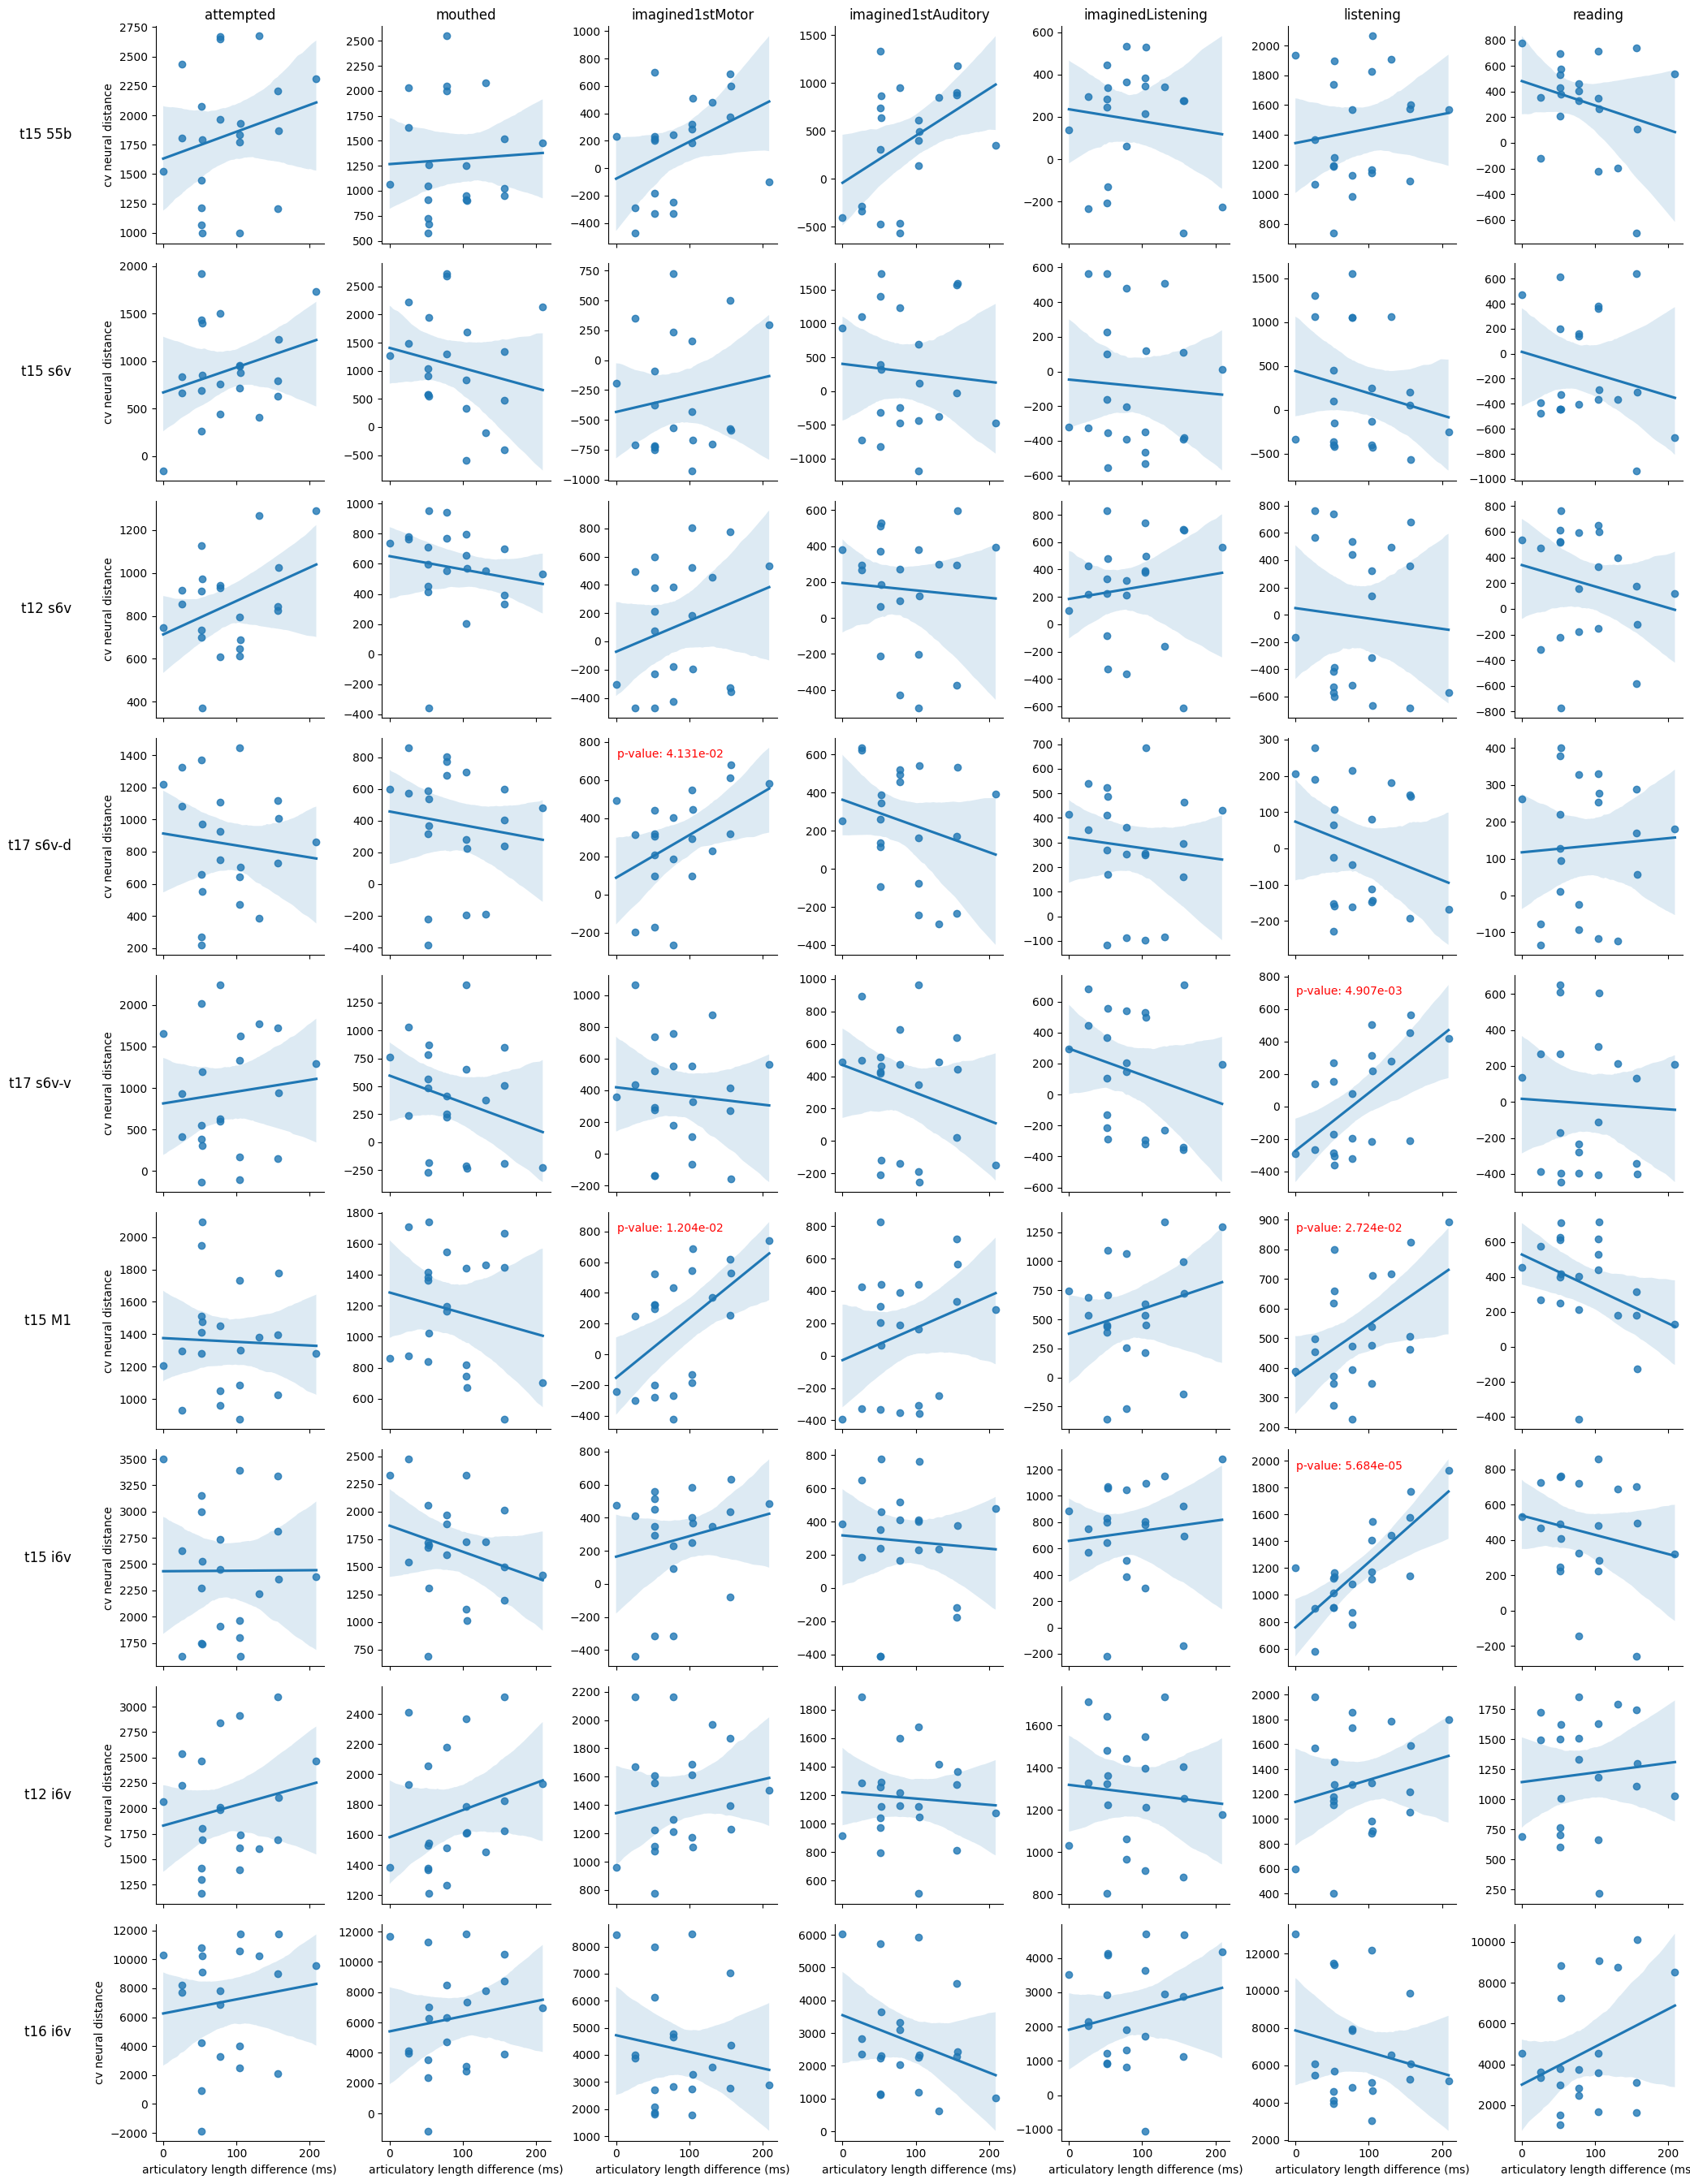

In [13]:
# Create a FacetGrid
g = sns.FacetGrid(neural_dist_bet_words[neural_dist_bet_words.participant_area.isin(PARTICIPANT_ARRAYS_PLOTTING)], 
                  row='participant_area', col='behavior', 
                  row_order = PARTICIPANT_ARRAYS_PLOTTING, col_order = BEHAVIORS, sharey=False)

# Function to perform linear regression and annotate the plot
def regplot_with_pvalue(data, x, y, alpha=0.05, **kwargs):
    sns.regplot(data=data, x=x, y=y, **kwargs)
    
    # Perform linear regression
    X = sm.add_constant(data[x])
    model = sm.OLS(data[y], X).fit()
    p_value = model.pvalues.iloc[1]  # p-value for the slope
    
    # Annotate the plot with the p-value
    if p_value < alpha:
        plt.gca().annotate(f'p-value: {p_value:.3e}', xy=(0.05, 0.95), xycoords='axes fraction', 
                           ha='left', va='top', fontsize=10, color='red')

# Map the regplot_with_pvalue function to the FacetGrid
g.map_dataframe(regplot_with_pvalue, x='articulatory length difference (ms)', y='cv neural distance')

# Hide the default axis titles
for ax in g.axes.flatten():
    ax.set_title('')

# Add custom row and column titles
# Add custom row and column titles
for i, ax in enumerate(g.axes[:, 0]):
    ax.annotate(g.row_names[i], xy=(-0.5, 0.5), xycoords='axes fraction', ha='right', va='center', fontsize='large', rotation=0)

for ax, col_val in zip(g.axes[0,:], g.col_names):
    ax.set_title(col_val, size='large')

# Adjust layout
plt.tight_layout()
plt.show()


In [14]:
corrs

NameError: name 'corrs' is not defined

In [122]:
corrs[BEHAVIORS]

behavior          attempted   mouthed  imagined1stMotor  imagined1stAuditory  \
participant_area                                                               
t12 i6v            0.192229  0.244481          0.161724            -0.072695   
t12 s6v            0.370184 -0.161038          0.263670            -0.067160   
t15 55b            0.220320  0.050645          0.396278             0.431889   
t15 M1            -0.036618 -0.181738          0.537149             0.269127   
t15 i6v            0.004165 -0.273286          0.209614            -0.063629   
t15 s6v            0.277819 -0.201812          0.152573            -0.076889   
t16 6d            -0.110129 -0.189303          0.065927            -0.161942   
t16 PEF            0.479951 -0.119707         -0.104575            -0.234676   
t16 i6v            0.129525  0.151722         -0.146511            -0.287164   
t17 55b           -0.011337 -0.168737          0.434899             0.064702   
t17 s6v-d         -0.109620 -0.123599          0.448736            -0.246786   
t17 s6v-v          0.103365 -0.263919         -0.085107            -0.242487   

behavior          imaginedListening  listening   reading  
participant_area                                          
t12 i6v                   -0.083660   0.221205  0.088887  
t12 s6v                    0.123327  -0.073916 -0.199462  
t15 55b                   -0.111678   0.136420 -0.268599  
t15 M1                     0.239885   0.481122 -0.371409  
t15 i6v                    0.102687   0.763342 -0.196314  
t15 s6v                   -0.057559  -0.194808 -0.206714  
t16 6d                     0.136592   0.015049 -0.226208  
t16 PEF                    0.437035  -0.054458  0.170333  
t16 i6v                    0.199810  -0.201854  0.338069  
t17 55b                    0.101180  -0.131623 -0.114462  
t17 s6v-d                 -0.098140  -0.255092  0.056334  
t17 s6v-v                 -0.238856   0.589625 -0.040782

In [123]:
BEHAVIORS

['attempted',
 'mouthed',
 'imagined1stMotor',
 'imagined1stAuditory',
 'imaginedListening',
 'listening',
 'reading']

In [124]:
BEHAVIORS_PLOTTING_RELABELED

['Attempted',
 'Mimed',
 'Motoric Inner Speech',
 'Auditory Inner Speech',
 'Imagined Listening',
 'Listening',
 'Silent Reading']

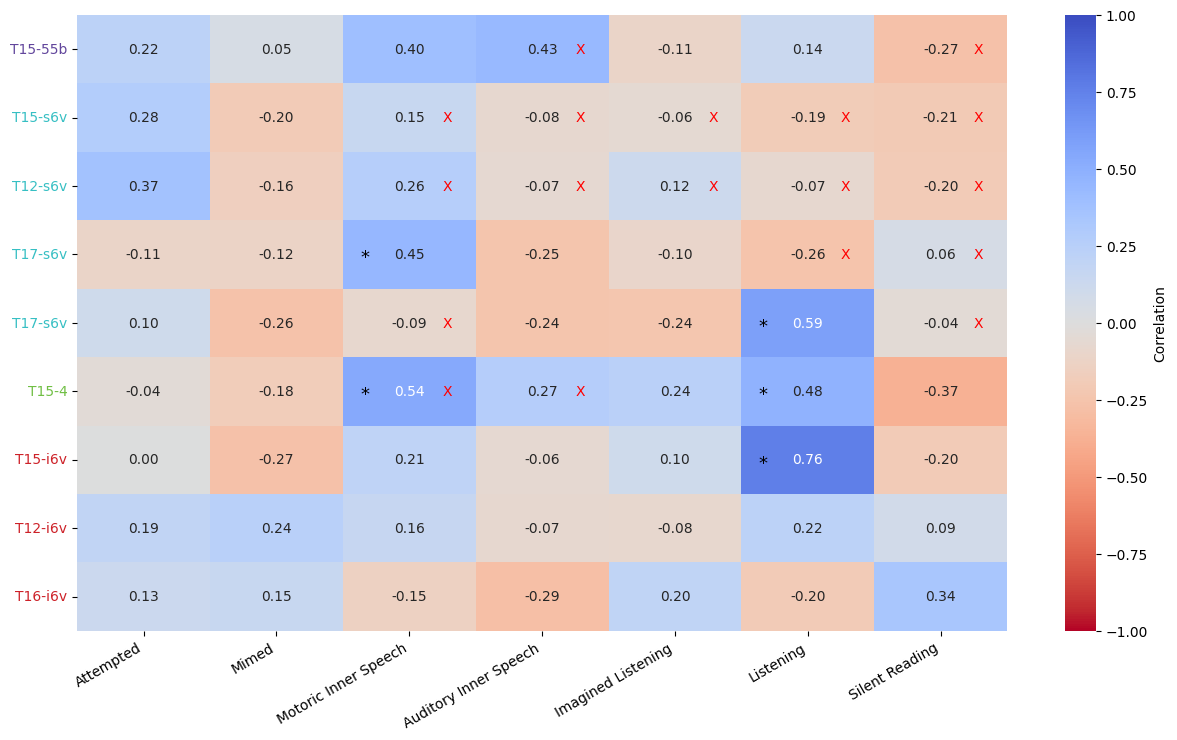

In [77]:
# summarize above plot as a heat map of correlation coefficients with red X if significant
# get correlation coefficients and p-values
# get p-values
def OLS_coefficient_pvalue_groupby(data):
    X = sm.add_constant(data['articulatory length difference (ms)'])
    y = data['cv neural distance']
    model = sm.OLS(y, X).fit()
    return model.pvalues.iloc[1]

def plot_articulatory_length_tuning(neural_dist_bet_words, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 8))

    corrs = neural_dist_bet_words.groupby(['participant_area', 'behavior']).apply(lambda x: x[['articulatory length difference (ms)', 'cv neural distance']].corr().iloc[0,1])
    # get arrays and behaviors in the right order to mirror figure 1
    corrs = corrs.unstack().loc[PARTICIPANT_ARRAYS_PLOTTING, BEHAVIORS]

    pvalues = neural_dist_bet_words.groupby(['participant_area', 'behavior']).apply(OLS_coefficient_pvalue_groupby)
    pvalues = pvalues.unstack()

    # plot as heatmap
    sns.heatmap(corrs, annot=True, fmt=".2f", cmap='coolwarm_r', ax=ax, vmin=-1, vmax=1, cbar_kws={'label': 'Correlation'})

    # draw x next to correlation for significant p-values
    for i, row in enumerate(corrs.index):
        for j, col in enumerate(corrs.columns):
            if pvalues.loc[row, col] < 0.05:
                ax.text(j+0.2, i+0.55, '*', ha='right', va='center', color='black', fontsize=13) # indicate significant tuning for articualtory length
            if (row, col) in NOT_SIGNIFICANT_DECODING_ARRAYS_FIGURE1:
                ax.text(j+0.75, i+0.5, 'X', ha='left', va='center', color='red', fontsize=10)  # indicate significant decoding between words
                

    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticks(ticks=np.arange(len(BEHAVIORS_PLOTTING_RELABELED))+0.5, labels=BEHAVIORS_PLOTTING_RELABELED, rotation=30, ha='right')
    ax.set_yticks(ticks=np.arange(len(PARTICIPANT_ARRAYS_PLOTTING_RELABELED))+0.5, labels=PARTICIPANT_ARRAYS_PLOTTING_RELABELED, rotation=0)
    # Set the colors of the tick labels based on PARTICIPANT_ARRAYS_PLOTTING_RELABELED_COLORS
    for tick_label, color in zip(ax.get_yticklabels(), PARTICIPANT_ARRAYS_PLOTTING_RELABELED_COLORS):
        tick_label.set_color(color)

plot_articulatory_length_tuning(neural_dist_bet_words)

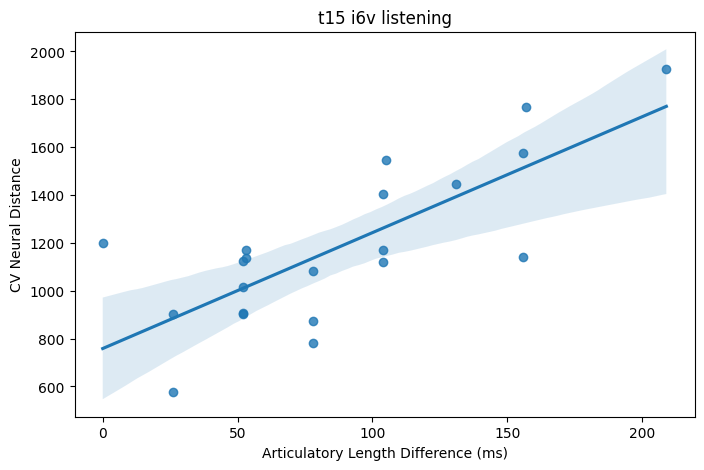

In [65]:
def plot_single_array_bhvr_artic_tuning(neural_dist_bet_words, array='t15 i6v', behavior = 'listening', ax=None, sns_kwargs={}):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 5))
    arr_bhvr_mask = (neural_dist_bet_words['participant_area'] == array) & (neural_dist_bet_words['behavior'] == behavior)
    sns.regplot(data=neural_dist_bet_words[arr_bhvr_mask], x='articulatory length difference (ms)', y='cv neural distance', ax=ax, **sns_kwargs)
    ax.set_title(f'{array} {behavior}')
    ax.set_xlabel('Articulatory Length Difference (ms)')
    ax.set_ylabel('CV Neural Distance')
    
plot_single_array_bhvr_artic_tuning(neural_dist_bet_words, array='t15 i6v', behavior = 'listening')

In [ ]:
# to show that there is no trend of articulatory length correlation with decoding accuracy I will scatter decoding accuracy with articulatory length corelation
neural_dist_bet_words.set_index(['participant', 'area', 'behavior', 'word_pair'],inplace=True)

participants = []
arrays = []
behavior = []
corr = []
for participant, areas in PARTICIPANT_ARRAYS_WIN_IDXS.items():
    for area in areas:
        for bhvr in BEHAVIORS:
            # get pearsons r between neural and articulatory distances
            corr.append(np.corrcoef(neural_dist_bet_words.loc[(participant, area, bhvr), 'cv neural distance'], neural_dist_bet_words.loc[(participant, area, bhvr), 'articulatory length difference (ms)'])[0,1])

            participants.append(participant)
            arrays.append(area)
            behavior.append(bhvr)
neural_dist_bet_words.reset_index(inplace=True)
articulatory_len_corr = pd.DataFrame({'participant': participants, 'array': arrays, 'behavior': behavior, 'pearsons r': corr})

/var/folders/c6/fcmdv2xj6wx7342n2dl_kblm0000gn/T/ipykernel_63028/3216495515.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  corr.append(np.corrcoef(neural_dist_bet_words.loc[(participant, area, bhvr), 'cv neural distance'], neural_dist_bet_words.loc[(participant, area, bhvr), 'articulatory length difference (ms)'])[0,1])


In [38]:
decoding_vs_articlatory_len = pd.merge(decoding_accuracies, articulatory_len_corr, on=['participant', 'array', 'behavior'])
decoding_vs_articlatory_len['participant array'] = decoding_vs_articlatory_len['participant'] + ' ' + decoding_vs_articlatory_len['array']
decoding_vs_articlatory_len

participant array             behavior  decoding_accuracy  pearsons r  \
0          t12   i6v            attempted           0.939524    0.192229   
1          t12   i6v              mouthed           0.801905    0.244481   
2          t12   i6v     imagined1stMotor           0.611842    0.161724   
3          t12   i6v  imagined1stAuditory           0.615263   -0.072695   
4          t12   i6v    imaginedListening           0.540000   -0.083660   
..         ...   ...                  ...                ...         ...   
79         t17   55b     imagined1stMotor           0.135714    0.434899   
80         t17   55b  imagined1stAuditory           0.207143    0.064702   
81         t17   55b    imaginedListening           0.178571    0.101180   
82         t17   55b            listening           0.164286   -0.131623   
83         t17   55b              reading           0.164286   -0.114462   

   participant array  
0            t12 i6v  
1            t12 i6v  
2            t12 i6v  
3            t12 i6v  
4            t12 i6v  
..               ...  
79           t17 55b  
80           t17 55b  
81           t17 55b  
82           t17 55b  
83           t17 55b  

[84 rows x 6 columns]

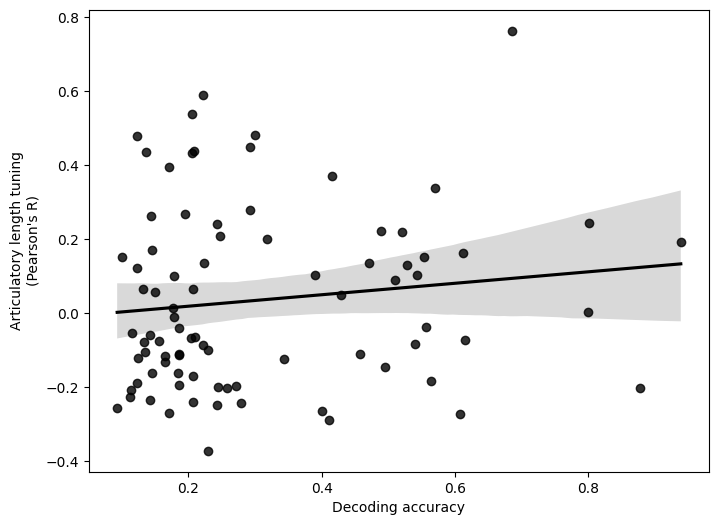

In [39]:
def plot_artic_tuning_vs_decoding(decoding_vs_articlatory_len, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    sns.regplot(decoding_vs_articlatory_len, x='decoding_accuracy', y='pearsons r', color='k', ax=ax)
    ax.set_ylabel("Articulatory length tuning\n(Pearson's R)")
    ax.set_xlabel('Decoding accuracy')

plot_artic_tuning_vs_decoding(decoding_vs_articlatory_len)

## Results
Reviewer 3 suggests a useful control to probe whether decodability between the 7 single syllable words is due to neural tuning for articulatory length of the the words rather than the phonemic content/articulatory sequence. To explore this, the population tuning for artiulatory length was assessed for each array/region. Articulatory length was quantified for each word using a text-to-speech model (AWS Polly, voice=Joanna). If population activity that could decode between words due to articulatory length, then the differences between the encoding of words in neural space should match the differences in articulatory length. For each array/region and behavioral instruction, the pairwise neural distance and articulatory length difference were calcualted for all pairs of the set of single syllable words. 

Significant tuning for articulatory length was found in 8/84 comparisons (significant correlation between articualtory length and neural distance differences for word pairs, p<0.05 for slope of ordinary least squares linear regression) but there was no relationshop between the strength of articulatory tuning and decoding accuracy across all participants and brain regions. Therefore, decodability between words across behaviors is not due to neural tuning for articulatory length of words. 

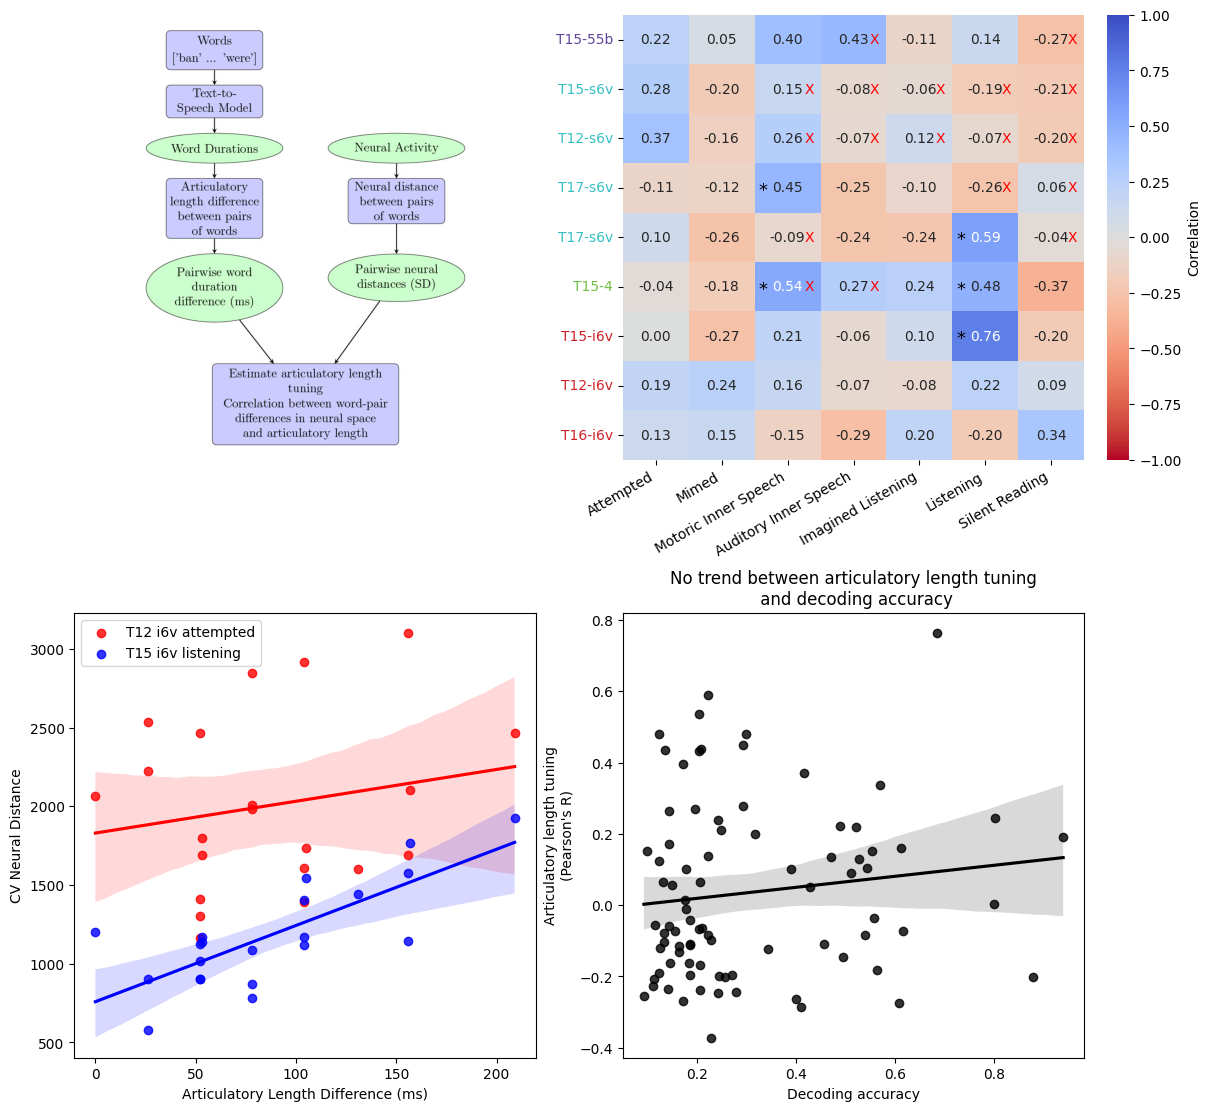

In [ ]:
# nb_dir = os.path.join(*IPython.extract_module_locals()[1]['__vsc_ipynb_file__'].split(os.path.sep)[:-1]) # note specific to using vscode
# diagram_path = os.path.join(os.path.sep, nb_dir, 'analysis_diagram.jpg')
diagram_path = os.path.join('..','subpanels', 'analysis_diagram.jpg')


# fig, axd = plt.subplot_mosaic([['analysis description','analysis description','atric len tuning all arrays','atric len tuning all arrays','atric len tuning all arrays', 'atric len tuning all arrays'],
#                                ['best decoding array artic tuning', 'best decoding array artic tuning', 't15 i6v listening tuning', 't15 i6v listening tuning', 'artic tuning vs decoding acc', 'artic tuning vs decoding acc']],
#                               figsize=(13, 11), layout="constrained", height_ratios=height_ratios)
fig, axd = plt.subplot_mosaic([['analysis description','analysis description','atric len tuning all arrays','atric len tuning all arrays'],
                               ['best decoding array artic tuning', 'best decoding array artic tuning','artic tuning vs decoding acc', 'artic tuning vs decoding acc']],
                              figsize=(12, 11), layout="constrained")

axd['analysis description'].axis('off')
axd['analysis description'].imshow(plt.imread(diagram_path))
plot_articulatory_length_tuning(neural_dist_bet_words, ax=axd['atric len tuning all arrays'])
plot_single_array_bhvr_artic_tuning(neural_dist_bet_words, array='t12 i6v', behavior = 'attempted', ax=axd['best decoding array artic tuning'], sns_kwargs={'label': 'T12 i6v attempted', 'color': 'red'})
plot_single_array_bhvr_artic_tuning(neural_dist_bet_words, array='t15 i6v', behavior = 'listening', ax=axd['best decoding array artic tuning'], sns_kwargs={'label': 'T15 i6v listening', 'color': 'blue'})
axd['best decoding array artic tuning'].legend()
axd['best decoding array artic tuning'].set_title('')
# plot_single_array_bhvr_artic_tuning(neural_dist_bet_words, array='t15 i6v', behavior = 'listening', ax=axd['t15 i6v listening tuning'])

# axd['t15 i6v listening tuning'].set_title('Articulatory length tuning\nT15 i6v listening')
# axd['best decoding array artic tuning'].set_title('Articulatory length tuning\nT12 i6v attempted')
# axd['t15 i6v listening tuning'].set_ylabel('')
# axd['t15 i6v listening tuning'].sharey(axd['best decoding array artic tuning'])
# plt.setp(axd['t15 i6v listening tuning'].get_yticklabels(), visible=False) 

plot_artic_tuning_vs_decoding(decoding_vs_articlatory_len, ax=axd['artic tuning vs decoding acc'])
axd['artic tuning vs decoding acc'].set_title('No trend between articulatory length tuning\n and decoding accuracy')

plt.savefig(FP_SVG_OUT)
plt.savefig(FP_PNG_OUT)

**Supplementary Figure 2**: Neural tuning for articulatory length does not explain separability between words.
We explore whether neural encoding of articulatory length could explain 7 word decoding performance. **A**) Diagram of estimate of articulatory length tuning per Utah array. Text-to-speech models were used to generate audio for individual words. Pairwise differences between word audio durations were compared with pairwise differences in neural distance. If articulatory length is encoded in neural population activity, neural differences would be explained by differences in articulatory length. **B**) Articulatory length tuning was computed for each Utah array and speech behavior matching Figure 1E. Black asterixis indicate significant tuning for articulatory length (Ordinary Least Squares regression coefficient p-value < 0.05). Red X's indicate arrays that do not have significant decoding of seven words reported in Figure 1E. Most arrays with significant decoder performance do not significantly encode articulatory length. **C**) Two example scatter plots of differences for each word pair in neural distance and articulatory length shown for the highest decoding performance array and behavior (T12 i6v Attempted, red) and highest articulatory tuning array and behavior (T15 i6v Listening, blue, p-value=5.68 x 10^-5) **D**) Although some behaviors in some arrays do have significant tuning for articulatory length, no sigificant relationship between articulatory length and decoding accuracy was found across all behaviors on all arrays.